<a href="https://colab.research.google.com/github/zaegeon/Python/blob/main/ML/20220617_ML06_regression_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
fish_csv = 'https://github.com/rickiepark/hg-mldl/raw/master/fish.csv'
fish = pd.read_csv(fish_csv)

물고기(Perch, 농어)의 무게 예측

`Weight ~ Length + Diagonal + Height + Width`

In [ ]:
perch = fish[fish.Species == 'Perch']

In [ ]:
perch.head()

,Species,Weight,Length,Diagonal,Height,Width
72,Perch,5.9,8.4,8.8,2.1120,1.4080
73,Perch,32.0,13.7,14.7,3.5280,1.9992
74,Perch,40.0,15.0,16.0,3.8240,2.4320
75,Perch,51.5,16.2,17.2,4.5924,2.6316
76,Perch,70.0,17.4,18.5,4.5880,2.9415


In [ ]:
pd.options.display.max_rows = 10

In [ ]:
perch[['Length', 'Diagonal', 'Height', 'Width']]

,Length,Diagonal,Height,Width
72,8.4,8.8,2.1120,1.4080
73,13.7,14.7,3.5280,1.9992
74,15.0,16.0,3.8240,2.4320
75,16.2,17.2,4.5924,2.6316
76,17.4,18.5,4.5880,2.9415
...,...,...,...,...
123,42.0,44.6,12.8002,6.8684
124,43.0,45.2,11.9328,7.2772
125,43.0,45.5,12.5125,7.4165
126,43.5,46.0,12.6040,8.1420


In [ ]:
# 특성 배열
X = perch.iloc[:, 2:].values.copy()

In [ ]:
# 타겟 배열
y = perch['Weight'].values.copy()

# train/test split

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y,
                                          test_size=0.25,
                                          random_state=42)

In [ ]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((42, 4), (14, 4), (42,), (14,))

# 1차항만 고려한 회귀

## KNN Regressor

In [ ]:
knn = KNeighborsRegressor()

In [ ]:
knn.fit(X_tr, y_tr)

KNeighborsRegressor()

In [ ]:
tr_pred = knn.predict(X_tr)

In [ ]:
# 훈련 셋 평가점수 : MSE, R2 score
print('MSE :', mean_squared_error(y_tr, tr_pred))
print('r2 :', r2_score(y_tr, tr_pred))

MSE : 2986.5723809523806
r2 : 0.97579760182756


In [ ]:
# 학습에 사용되지 않은 테스트 셋의 예측값
te_pred = knn.predict(X_te)
te_pred

array([  60. ,   79.6,  248. ,  122. ,  130. ,  847. ,  311.4,  183.4,
        847. ,  118. , 1043. ,   60. ,  248. ,  248. ])

In [ ]:
# 테스트 셋 평가점수 : MSE, R2 score
print('MSE :', mean_squared_error(y_te, te_pred))
print('r2 :', r2_score(y_te, te_pred))

MSE : 837.3100000000001
r2 : 0.9916579819676246


테스트 셋에서의 평가 점수가 훈련 셋에서의 점수보다 좋음 → 과소적합

# Linear Regression

$$
y = w_0 + w_1 \times x_1 + w_2 \times x_2 + w_3 \times x_3 + w_4 \times x_4
$$

In [ ]:
lin_reg = LinearRegression() # 선형 회귀 모델 생성

In [ ]:
lin_reg.fit(X_tr, y_tr) # 모델 훈련

LinearRegression()

In [ ]:
lin_reg.intercept_ # 선형회귀식에서 w0

-610.0275364260515

In [ ]:
lin_reg.coef_ # 선형회귀식에서 w1~w4

array([-40.18338554,  47.80681727,  67.34086612,  35.34904264])

In [ ]:
# 훈련 셋 예측값
tr_pred = lin_reg.predict(X_tr)

In [ ]:
# 훈련 셋 평가 점수
print('MSE :', mean_squared_error(y_tr, tr_pred))
print('r2 :', r2_score(y_tr, tr_pred))

MSE : 5340.176566753986
r2 : 0.9567246116638569


In [ ]:
# 테스트 셋 예측값
te_pred = lin_reg.predict(X_te)

In [ ]:
# 테스트 셋 평가 점수
print('MSE :', mean_squared_error(y_te, te_pred))
print('r2 :', r2_score(y_te, te_pred))

MSE : 12140.410523504848
r2 : 0.8790465615990273


훈련 셋의 점수가 테스트 셋의 점수보다 좋음 → 과대적합

# 2차항을 고려한 선형 회귀

$$
\hat{y} = w_0 + w_1 \times x_1 + \cdots + w_4 \times x_4 + w_5 \times {x_1}^2 + w_6 \times {x_2}^2 + w_7 \times x_1 x_2 + \cdots
$$

In [ ]:
poly = PolynomialFeatures(include_bias=False)
# degree=2 : 기본값. 2차항까지만 고려.
# interaction_only=Fasle : 기본값. x1^2, x2^2, x1x2, ... 등을 모두 추가
#   True로 설정하면 제곱항들은 무시되고 interaction 항들만 추가됨.

In [ ]:
result = poly.fit_transform(X_tr)

In [ ]:
result[:2]

array([[ 19.6       ,  20.8       ,   5.1376    ,   3.0368    ,
        384.16      , 407.68      , 100.69696   ,  59.52128   ,
        432.64      , 106.86208   ,  63.16544   ,  26.39493376,
         15.60186368,   9.22215424],
       [ 22.        ,  23.5       ,   5.875     ,   3.525     ,
        484.        , 517.        , 129.25      ,  77.55      ,
        552.25      , 138.0625    ,  82.8375    ,  34.515625  ,
         20.709375  ,  12.425625  ]])

In [ ]:
poly.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x1^2',
       'x1 x2', 'x1 x3', 'x2^2', 'x2 x3', 'x3^2'], dtype=object)

In [ ]:
poly = PolynomialFeatures(include_bias=False, interaction_only=True)

In [ ]:
result = poly.fit_transform(X_tr)
result[:2]

array([[ 19.6       ,  20.8       ,   5.1376    ,   3.0368    ,
        407.68      , 100.69696   ,  59.52128   , 106.86208   ,
         63.16544   ,  15.60186368],
       [ 22.        ,  23.5       ,   5.875     ,   3.525     ,
        517.        , 129.25      ,  77.55      , 138.0625    ,
         82.8375    ,  20.709375  ]])

## 2차항 추가, Scaling 하지 않는 경우

In [ ]:
poly = PolynomialFeatures(include_bias=False) # 변환기(Transformer) - fit, transform
lin_reg = LinearRegression() # 예측기(Estimator) - fit, predict, score
# 변환기와 예측기 연결된 파이프라인 → 머신 러닝 모델
model = Pipeline([('poly', poly), ('lin_reg', lin_reg)])

In [ ]:
model.fit(X_tr, y_tr) # 모델 훈련
# (1) poly.fit_transform() → (2) lin_reg.fit(X_tr_trans, y_tr)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('lin_reg', LinearRegression())])

In [ ]:
model['poly'].get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x1^2',
       'x1 x2', 'x1 x3', 'x2^2', 'x2 x3', 'x3^2'], dtype=object)

In [ ]:
model['lin_reg'].coef_

array([ -50.78509594,  124.88041222, -226.27583652, -211.15974936,
        219.94801311, -378.27754255, -310.06984107,  301.69060933,
        155.92749428,  315.3374506 , -269.45161891,   24.76034853,
       -176.24019353,  126.39216926])

In [ ]:
# 훈련 셋 예측값
tr_pred = model.predict(X_tr)
# (1) poly.transform(X_tr) → (2) lin_reg.predict(X_tr_trans)

In [ ]:
# 훈련 셋 평가 점수
print('MSE :', mean_squared_error(y_tr, tr_pred))
print('r2 :', r2_score(y_tr, tr_pred))

MSE : 986.5134830835684
r2 : 0.9920055538341062


In [ ]:
# 테스트 셋 예측값
te_pred = model.predict(X_te)

In [ ]:
# 테스트 셋 평가 점수
print('MSE :', mean_squared_error(y_te, te_pred))
print('r2 :', r2_score(y_te, te_pred))

MSE : 5092.809112559572
r2 : 0.9492609601552375


## 2차항 추가, Scaling 하는 경우

In [ ]:
# pipeline = poly + scaler + regressor
poly = PolynomialFeatures(include_bias=False) # 변환기(Transformer) - fit, transform
lin_reg = LinearRegression() # 예측기(Estimator) - fit, predict, score
# 변환기와 예측기 연결된 파이프라인 → 머신 러닝 모델
model = Pipeline([('poly', poly), ('scaler', StandardScaler()), ('reg', lin_reg)])

In [ ]:
# 모델 훈련 : poly.fit_transform(X_tr) → scaler.fit_transform(X_tr_p) → reg.fit(X_tr_p, y_tr)
model.fit(X_tr, y_tr)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('reg', LinearRegression())])

In [ ]:
# 훈련 셋 예측값
# poly.transform(X_tr) → scaler.transform(X_tr_p) → reg.predict(X_tr_p_s)
tr_pred = model.predict(X_tr)

In [ ]:
# 훈련 셋 평가 점수
print('MSE :', mean_squared_error(y_tr, tr_pred))
print('r2 :', r2_score(y_tr, tr_pred))

MSE : 986.5134830823616
r2 : 0.9920055538341159


In [ ]:
# 테스트 셋 예측값
te_pred = model.predict(X_te)

In [ ]:
# 테스트 셋 평가 점수
print('MSE :', mean_squared_error(y_te, te_pred))
print('r2 :', r2_score(y_te, te_pred))

MSE : 5092.809112554763
r2 : 0.9492609601552854


# 5차항까지 추가, Scaling하는 경우

In [ ]:
poly = PolynomialFeatures(degree=5, include_bias=False)
lin_reg = LinearRegression()
model = Pipeline([('poly', poly), ('scaler', StandardScaler()), ('lin_reg', lin_reg)])

In [ ]:
model.fit(X_tr, y_tr) # 모델 훈련

Pipeline(steps=[('poly', PolynomialFeatures(degree=5, include_bias=False)),
                ('scaler', StandardScaler()), ('lin_reg', LinearRegression())])

In [ ]:
model['poly'].get_feature_names_out()

array(['x0', 'x1', 'x2', 'x3', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x1^2',
       'x1 x2', 'x1 x3', 'x2^2', 'x2 x3', 'x3^2', 'x0^3', 'x0^2 x1',
       'x0^2 x2', 'x0^2 x3', 'x0 x1^2', 'x0 x1 x2', 'x0 x1 x3', 'x0 x2^2',
       'x0 x2 x3', 'x0 x3^2', 'x1^3', 'x1^2 x2', 'x1^2 x3', 'x1 x2^2',
       'x1 x2 x3', 'x1 x3^2', 'x2^3', 'x2^2 x3', 'x2 x3^2', 'x3^3',
       'x0^4', 'x0^3 x1', 'x0^3 x2', 'x0^3 x3', 'x0^2 x1^2', 'x0^2 x1 x2',
       'x0^2 x1 x3', 'x0^2 x2^2', 'x0^2 x2 x3', 'x0^2 x3^2', 'x0 x1^3',
       'x0 x1^2 x2', 'x0 x1^2 x3', 'x0 x1 x2^2', 'x0 x1 x2 x3',
       'x0 x1 x3^2', 'x0 x2^3', 'x0 x2^2 x3', 'x0 x2 x3^2', 'x0 x3^3',
       'x1^4', 'x1^3 x2', 'x1^3 x3', 'x1^2 x2^2', 'x1^2 x2 x3',
       'x1^2 x3^2', 'x1 x2^3', 'x1 x2^2 x3', 'x1 x2 x3^2', 'x1 x3^3',
       'x2^4', 'x2^3 x3', 'x2^2 x3^2', 'x2 x3^3', 'x3^4', 'x0^5',
       'x0^4 x1', 'x0^4 x2', 'x0^4 x3', 'x0^3 x1^2', 'x0^3 x1 x2',
       'x0^3 x1 x3', 'x0^3 x2^2', 'x0^3 x2 x3', 'x0^3 x3^2', 'x0^2 x1^3',
       'x0^2 x1^2 x2

In [ ]:
# 훈련 셋 예측값
tr_pred = model.predict(X_tr)

In [ ]:
# 훈련 셋 평가 점수
print('MSE :', mean_squared_error(y_tr, tr_pred))
print('r2 :', r2_score(y_tr, tr_pred))

MSE : 4.351506028418873e-17
r2 : 1.0


In [ ]:
# 테스트 셋 예측값
te_pred = model.predict(X_te)

In [ ]:
# 테스트 셋 평가 점수
print('MSE :', mean_squared_error(y_te, te_pred))
print('r2 :', r2_score(y_te, te_pred))

MSE : 14199476.804941649
r2 : -140.46766616560245


5차항까지 고려했을 때 선형 회귀 모델은 과대적합이 너무 심한 모델.

→ 일반화 성능이 안 좋음.

# 규제가 없는 선형회귀 - 과대적합

In [ ]:
X = perch[['Length']].values.copy()
y = perch['Weight'].values.copy()

In [ ]:
X.shape, y.shape

((56, 1), (56,))

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y,
                                          test_size=0.25,
                                          random_state=42)

In [ ]:
# 모델 생성
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('Scaler', StandardScaler()),
                  ('reg', LinearRegression())])

In [ ]:
# 모델 훈련
model.fit(X_tr, y_tr)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('Scaler', StandardScaler()), ('reg', LinearRegression())])

In [ ]:
model['reg'].coef_

array([340.55381311])

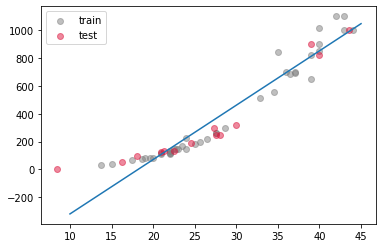

In [ ]:
# 훈련 셋 산점도
plt.scatter(X_tr, y_tr, alpha=0.5, label='train', color='gray')

# 테스트 셋 산점도
plt.scatter(X_te, y_te, alpha=0.5, label='test', color='crimson')

# 선형 회귀 곡선 시각화
X_vals = np.arange(10, 45, 0.001).reshape((-1, 1))
y_vals = model.predict(X_vals)
plt.plot(X_vals, y_vals)

plt.legend()
plt.show()

In [ ]:
def visualize_regression(X_tr, y_tr, X_te, y_te, degrees, estimator):
    plt.figure(figsize=(10, 10))

    # 훈련 셋 산점도
    plt.scatter(X_tr, y_tr, alpha=0.5, label='train', color='darkgray')

    # 테스트 셋 산점도
    plt.scatter(X_te, y_te, alpha=0.5, label='test', color='orange')

    for d in degrees:
        # Pipeline(PolynomialFeatures → StandardScaler → LinearRegressor) 생성
        model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                        ('scaler', StandardScaler()),
                        ('reg', estimator)])
        # 모델을 훈련 데이터로 학습시킴.
        model.fit(X_tr, y_tr)
        print('degree =', d, ':', model['reg'].coef_)
        # 회귀식 시각화하기 위해서
        X_vals = np.arange(10, 45, 0.001).reshape((-1, 1)) # 회귀식 시각화에 필요한 x좌표
        y_vals = model.predict(X_vals) # 회귀식 시각화에 필요한 y좌표
        plt.plot(X_vals, y_vals, label=f'degree={d}')

    plt.ylim((-100, 1200))
    plt.grid()
    plt.legend()
    plt.show()

degree = 1 : [340.55381311]
degree = 2 : [-188.16429447  532.30423546]
degree = 5 : [ 1090.51349849 -4377.12096334  5960.80924384 -2038.47216236
  -298.04297802]
degree = 50 : [ 6.98882833e+11 -1.00258489e+13  6.60296042e+13 -2.55034855e+14
  6.09952960e+14 -8.49257804e+14  4.52273759e+14  4.19689312e+14
 -5.51591443e+14 -3.28854741e+14  4.59197104e+14  4.64717683e+14
 -2.50299728e+14 -5.52393976e+14 -1.60092632e+14  3.91786172e+14
  5.11210317e+14  7.31510052e+13 -3.53270642e+14 -4.94712910e+14
 -1.96230307e+14  2.13080773e+14  4.96213319e+14  3.80309385e+14
  1.75066814e+13 -3.44230648e+14 -4.87250016e+14 -3.02344800e+14
  2.62593791e+13  3.30040038e+14  4.73494550e+14  3.40422044e+14
  2.18521947e+13 -3.08247209e+14 -4.73280892e+14 -3.86850938e+14
 -8.61310505e+13  2.56242683e+14  4.63841120e+14  4.23130930e+14
  1.23033768e+14 -2.34060437e+14 -4.83471867e+14 -4.17931846e+14
 -4.03199922e+13  4.12817710e+14  5.76576966e+14  1.26944300e+13
 -7.83101811e+14  3.32763612e+14]


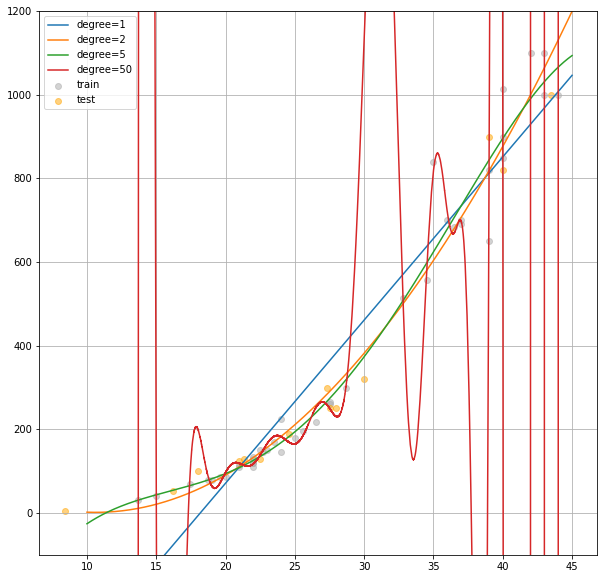

In [ ]:
degrees = (1, 2, 5, 50)
estimator = LinearRegression()
visualize_regression(X_tr, y_tr, X_te, y_te, degrees, estimator)

# 규제 (regularization)

*  머신 러닝의 목적은 목적 함수(objective function)/비용 함수(cost function)/손실 함수(loss function)을 최소화하는 것.
*  선형 회귀(linear regression)의 목적은 MSE(mean_squared_error)를 최소로 만드는 계수들($ w_0, ... , w_m $)을 찾는 것. 즉, 선형 회귀의 목적 함수는 MSE(w).
$$
J(w) = MSE(w) = \frac{1}{N}\sum^{N}_{i=1}(y_i - \hat{y_i})^2 = \frac{1}{N}\sum^{N}_{i=1}(y_i - (w_0 + \sum^{m}_{j=1} w_{j} \cdot x_{ij} ))^2
$$
    * $N$: 샘플의 개수(DataFrame의 row의 개수)
    * $m$: 특성의 개수(DataFrame의 column의 개수)
    * $y_i$: $i$번째 샘플의 실젯값
    * $\hat{y_i}$: $i$번째 샘플의 예측값
    * $x_{ij}$: $i$번째 샘플의 $j$번째 특성 값
    * $w_{j}$: $j$번째 특성에 곱해주는 계수(기울기)


* Ridge(`l2`) 규제의 목적은 아래의 비용 함수를 최소로 만드는 계수들($ w_0, ... , w_m $)을 찾는 것.

$$
J(w) = MSE(w) + \frac{\alpha}{2} ||w||^2
$$

> Ridge 규제의 효과는 고차항들의 계수(coefficients, 기울기)를 작게 만들어서 곡선의 기울기를 완만하게 만들어 주게 됨. overfitting(과대적합)을 줄여주게 됨.

* Lasso(`l1`) 규제의 목적은 아래의 비용 함수를 최소로 만드는 계수들($ w_0, ... , w_m $)을 찾는 것.

$$
J(w) = MSE(w) + \alpha ||w||
$$

> Lasso 규제는 중요하지 않은 고차항들의 계수를 0으로 만들어 줌으로써, 곡선을 완만하게 만들어 주는 효과가 생김. 과대적합을 줄여주는 효과.

* ElasticNet 규제의 목적은 아래의 비용 함수를 최소로 만드는 계수들($ w_0, ... , w_m $)을 찾는 것.

$$
J(w) = MSE(w) + r\alpha ||w|| + \frac{1-r}{2} \alpha ||w||^2
$$

>ElasticNet은 Ridge 규제와 Lasso 규제의 효과를 모두 가지고 있음.

* Ridge, Lasso에서 $\alpha$ 값이 크면 규제가 강해지고, $\alpha$ 값이 작으면 규제가 약해짐($\alpha \geq 0$).
* ElasticNet에서 $\alpha$는 규제의 크기를 의미하고, $r$은 `l1` 규제의 비율($ 0 \leq r \leq 1$)을 의미함.

## l2 규제 : Ridge

degree = 1 : [332.63395699]
degree = 2 : [ 90.58971122 249.48800198]
degree = 5 : [71.46390274 95.36902828 90.24481144 64.15690222 24.69095831]
degree = 50 : [57.071767   71.05492103 71.65634347 63.87632    51.92887907 38.82686003
 26.45737388 15.82631359  7.32628255  0.96590695 -3.45871369 -6.24793939
 -7.72662807 -8.20357587 -7.95156044 -7.19999236 -6.13474486 -4.9016977
 -3.61189738 -2.34712978 -1.16525955 -0.10502713  0.80981179  1.56701183
  2.16298141  2.6004731   2.88674253  3.03210024  3.04878761  2.95011641
  2.74982088  2.46157898  2.09866767  1.67372291  1.19858097  0.68418227
  0.14052254 -0.42336072 -0.99937571 -1.58034537 -2.1599636  -2.73274316
 -3.29395867 -3.83958717 -4.36624834 -4.87114565 -5.35200944 -5.8070427
 -6.23486993 -6.63448935]


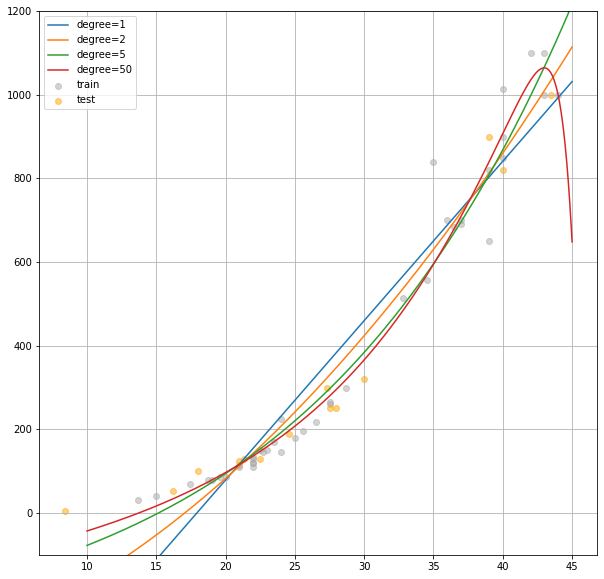

In [ ]:
estimator = Ridge()
visualize_regression(X_tr, y_tr, X_te, y_te, degrees, estimator)

In [ ]:
model = Pipeline([('poly', PolynomialFeatures(degree=50, include_bias=False)),
                  ('scaler', StandardScaler()),
                  ('reg', Ridge())])

In [ ]:
model.fit(X_tr, y_tr)

Pipeline(steps=[('poly', PolynomialFeatures(degree=50, include_bias=False)),
                ('scaler', StandardScaler()), ('reg', Ridge())])

In [ ]:
print('train r2:', model.score(X_tr, y_tr))
print('test r2:', model.score(X_te, y_te))

train r2: 0.9739229136053733
test r2: 0.9813385255457554


## l1 규제 : Lasso

degree = 1 : [339.55381311]
degree = 2 : [-24.15886941 368.40371318]
degree = 5 : [  0.         187.45257639 157.89610691   0.           0.        ]
degree = 50 : [  0.          96.03631633 194.22723322  72.8858871    0.
   0.           0.           0.           0.           0.
  -0.          -0.          -0.          -0.          -0.
  -0.          -0.          -0.          -0.          -0.
  -0.          -0.          -0.          -0.          -0.
  -0.          -0.          -0.          -0.          -0.
  -0.          -0.          -0.          -0.          -0.
  -0.          -0.          -0.          -0.          -0.
  -0.          -0.          -0.          -0.          -0.
  -0.          -0.          -6.24744375 -13.90628201 -13.30554271]


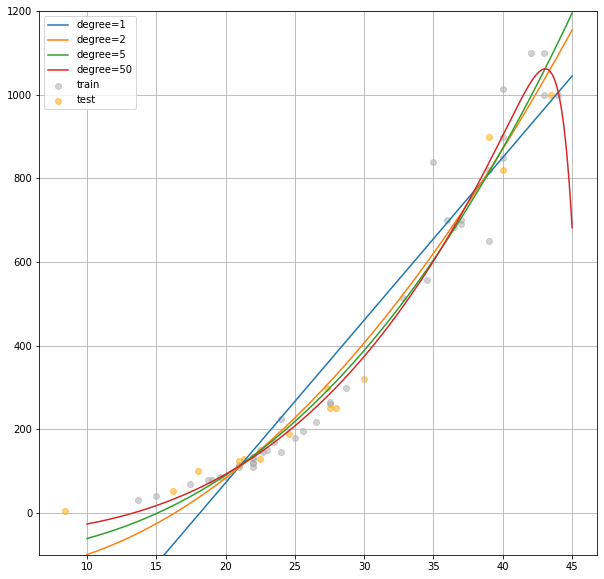

In [ ]:
estimator = Lasso(max_iter=10_000, tol=0.001)
visualize_regression(X_tr, y_tr, X_te, y_te, degrees, estimator)

# 규제 크기($\alpha$)에 따른 결정 계수의 변화

5차항까지 포함, StandardScalar 사용, 훈련 셋/테스트 셋에서의 r2 score를 계산, 시각화

train scores : [0.9729318909719307, 0.9694267645740603, 0.9669667595405638, 0.9574099753809557, 0.7128959260018337, 0.1419437414816156]
test scores : [0.9792791927855977, 0.9717021238527076, 0.9675102498277163, 0.9741613969257316, 0.7439362036454651, 0.10755935075190703]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.319e+04, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.688e+02, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


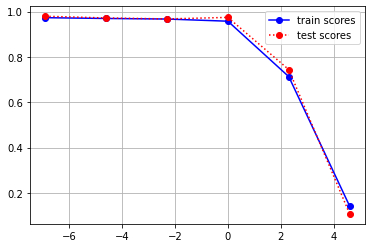

In [ ]:
train_scores = [] # 훈련 셋에서 계산한 결정계수를 저장할 리스트
test_scores = [] # 테스트 셋에서 계산한 결정계수를 저장할 리스트
alphas = [10 ** x for x in range(-3, 3)] # [0.001, 0.01, 0.1, 1, 10, 100]

for a in alphas:
    poly = PolynomialFeatures(degree=5, include_bias=False)
    scaler = StandardScaler()
    estimator = ElasticNet(alpha=a)
    model = Pipeline([('poly', poly), ('scaler', scaler), ('reg', estimator)])
    model.fit(X_tr, y_tr)
    train_r2 = model.score(X_tr, y_tr) # 훈련 셋 결정계수
    train_scores.append(train_r2)
    test_r2 = model.score(X_te, y_te) # 테스트 셋 결정계수
    test_scores.append(test_r2)

plt.plot(np.log(alphas), train_scores, 'bo-', label='train scores')
plt.plot(np.log(alphas), test_scores, 'ro:', label='test scores')
plt.grid()
plt.legend()

print('train scores :', train_scores)
print('test scores :', test_scores)

규제를 사용하면 과대적합을 줄이면서(없애면서) 일반화 성능을 좋게 만들고 있음.

## 농어 데이터의 모든 컬럼을 변수로 사용, Ridge, Lasso, ElasticNet 규제 크기에 따른 결정 계수 그래프.

In [ ]:
X = perch.iloc[:, 2:].values.copy()
y = perch['Weight'].values.copy()

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y,
                                          test_size=0.25,
                                          random_state=42)

In [ ]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((42, 4), (14, 4), (42,), (14,))

train scores : [0.9946716964073975, 0.9926658847510959, 0.9906588529802888, 0.9898642966685524, 0.9891003605036942, 0.9847161412052865]
test scores : [0.8805517581588203, 0.9675695452678644, 0.9829891528180518, 0.9805647119266162, 0.9749015716532, 0.9620345864309697]


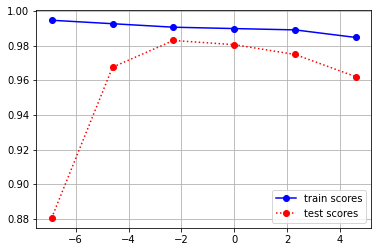

In [ ]:
train_scores = [] # 훈련 셋에서 계산한 결정계수를 저장할 리스트
test_scores = [] # 테스트 셋에서 계산한 결정계수를 저장할 리스트
alphas = [10 ** x for x in range(-3, 3)] # [0.001, 0.01, 0.1, 1, 10, 100]
for a in alphas:
    poly = PolynomialFeatures(degree=5, include_bias=False)
    scaler = StandardScaler()
    estimator = Ridge(alpha=a)
    model = Pipeline([('poly', poly), ('scaler', scaler), ('reg', estimator)])
    model.fit(X_tr, y_tr)
    train_r2 = model.score(X_tr, y_tr) # 훈련 셋 결정계수
    train_scores.append(train_r2)
    test_r2 = model.score(X_te, y_te) # 테스트 셋 결정계수
    test_scores.append(test_r2)

plt.plot(np.log(alphas), train_scores, 'bo-', label='train scores')
plt.plot(np.log(alphas), test_scores, 'ro:', label='test scores')
plt.grid()
plt.legend()

print('train scores :', train_scores)
print('test scores :', test_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.120e+04, tolerance: 5.183e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


train scores : [0.995299628429997, 0.9940725023435732, 0.9900933902196672, 0.9898000130537604, 0.9888486217703013, 0.9079687985326612]
test scores : [0.8362618256216907, 0.913262304058171, 0.9803174736331131, 0.9798508231795158, 0.9824280305768478, 0.9074703909908151]


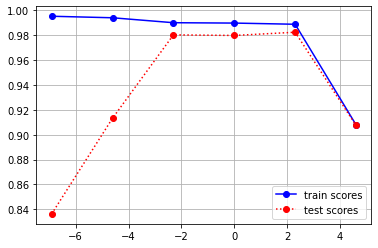

In [ ]:
train_scores = [] # 훈련 셋에서 계산한 결정계수를 저장할 리스트
test_scores = [] # 테스트 셋에서 계산한 결정계수를 저장할 리스트
alphas = [10 ** x for x in range(-3, 3)] # [0.001, 0.01, 0.1, 1, 10, 100]
for a in alphas:
    poly = PolynomialFeatures(degree=5, include_bias=False)
    scaler = StandardScaler()
    estimator = Lasso(alpha=a, max_iter=100_000, tol=0.001)
    model = Pipeline([('poly', poly), ('scaler', scaler), ('reg', estimator)])
    model.fit(X_tr, y_tr)
    train_r2 = model.score(X_tr, y_tr) # 훈련 셋 결정계수
    train_scores.append(train_r2)
    test_r2 = model.score(X_te, y_te) # 테스트 셋 결정계수
    test_scores.append(test_r2)

plt.plot(np.log(alphas), train_scores, 'bo-', label='train scores')
plt.plot(np.log(alphas), test_scores, 'ro:', label='test scores')
plt.grid()
plt.legend()

print('train scores :', train_scores)
print('test scores :', test_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.659e+04, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.034e+03, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


train scores : [0.9918680069055825, 0.9902982877266575, 0.9896451841030244, 0.9882895517028185, 0.9807297352710089, 0.8298002302295657]
test scores : [0.9780983353813979, 0.9826123398654909, 0.9788098964778946, 0.971406441339297, 0.9615684464630995, 0.8421891080992795]


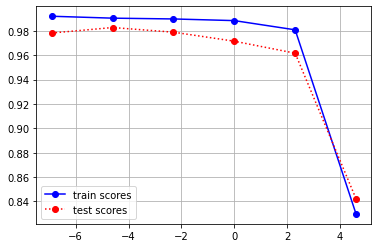

In [ ]:
train_scores = [] # 훈련 셋에서 계산한 결정계수를 저장할 리스트
test_scores = [] # 테스트 셋에서 계산한 결정계수를 저장할 리스트
alphas = [10 ** x for x in range(-3, 3)] # [0.001, 0.01, 0.1, 1, 10, 100]
for a in alphas:
    poly = PolynomialFeatures(degree=5, include_bias=False)
    scaler = StandardScaler()
    estimator = ElasticNet(alpha=a, max_iter=100_000)
    model = Pipeline([('poly', poly), ('scaler', scaler), ('reg', estimator)])
    model.fit(X_tr, y_tr)
    train_r2 = model.score(X_tr, y_tr) # 훈련 셋 결정계수
    train_scores.append(train_r2)
    test_r2 = model.score(X_te, y_te) # 테스트 셋 결정계수
    test_scores.append(test_r2)

plt.plot(np.log(alphas), train_scores, 'bo-', label='train scores')
plt.plot(np.log(alphas), test_scores, 'ro:', label='test scores')
plt.grid()
plt.legend()

print('train scores :', train_scores)
print('test scores :', test_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.120e+04, tolerance: 5.183e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.659e+04, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

Ridge train : [0.9946716964073975, 0.9926658847510959, 0.9906588529802888, 0.9898642966685524, 0.9891003605036942, 0.9847161412052865]
Ridge test : [0.8805517581588203, 0.9675695452678644, 0.9829891528180518, 0.9805647119266162, 0.9749015716532, 0.9620345864309697]
Lasso train : [0.995299628429997, 0.9940725023435732, 0.9900933902196672, 0.9898000130537604, 0.9888486217703013, 0.9079687985326612]
Lasso test : [0.8362618256216907, 0.913262304058171, 0.9803174736331131, 0.9798508231795158, 0.9824280305768478, 0.9074703909908151]
ElasticNet train : [0.9918680069055825, 0.9902982877266575, 0.9896451841030244, 0.9882895517028185, 0.9807297352710089, 0.8298002302295657]
ElasticNet test : [0.9780983353813979, 0.9826123398654909, 0.9788098964778946, 0.971406441339297, 0.9615684464630995, 0.8421891080992795]


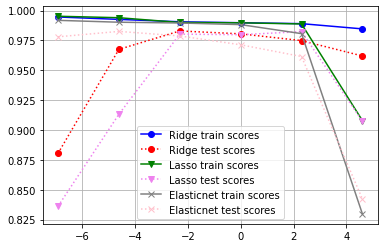

In [ ]:
ridge_train_scores = []
ridge_test_scores = []
lasso_train_scores = []
lasso_test_scores = []
elasticnet_train_scores = []
elasticnet_test_scores = []
alphas = [10 ** x for x in range(-3, 3)] # [0.001, 0.01, 0.1, 1, 10, 100]
reg = ['Ridge', 'Lasso', 'ElasticNet']
for a in alphas:
    poly = PolynomialFeatures(degree=5, include_bias=False)
    scaler = StandardScaler()
    for r in reg:
        if r == 'Ridge':
            estimator = Ridge(alpha=a)
        elif r == 'Lasso':
            estimator = Lasso(alpha=a, max_iter=100_000, tol=0.001)
        elif r == 'ElasticNet':
            estimator = ElasticNet(alpha=a, max_iter=100_000)
        model = Pipeline([('poly', poly), ('scaler', scaler), ('reg', estimator)])
        model.fit(X_tr, y_tr)
        train_r2 = model.score(X_tr, y_tr) # 훈련 셋 결정계수
        test_r2 = model.score(X_te, y_te) # 테스트 셋 결정계수
        if r == 'Ridge':
            ridge_train_scores.append(train_r2)
            ridge_test_scores.append(test_r2)
        elif r == 'Lasso':
            lasso_train_scores.append(train_r2)
            lasso_test_scores.append(test_r2)
        elif r == 'ElasticNet':
            elasticnet_train_scores.append(train_r2)
            elasticnet_test_scores.append(test_r2)
print('Ridge train :', ridge_train_scores)
print('Ridge test :', ridge_test_scores)
print('Lasso train :', lasso_train_scores)
print('Lasso test :', lasso_test_scores)
print('ElasticNet train :', elasticnet_train_scores)
print('ElasticNet test :', elasticnet_test_scores)

plt.plot(np.log(alphas), ridge_train_scores, 'bo-', label='Ridge train scores')
plt.plot(np.log(alphas), ridge_test_scores, 'ro:', label='Ridge test scores')
plt.plot(np.log(alphas), lasso_train_scores, 'gv-', label='Lasso train scores')
plt.plot(np.log(alphas), lasso_test_scores, color='violet', marker='v', linestyle=':', label='Lasso test scores')
plt.plot(np.log(alphas), elasticnet_train_scores, color = 'gray', marker='x', linestyle='-', label='Elasticnet train scores')
plt.plot(np.log(alphas), elasticnet_test_scores, color='pink', marker='x', linestyle=':', label='Elasticnet test scores')

plt.legend()
plt.grid()
plt.show()

In [ ]:
def visualize_r2_score(estimator, X_tr, y_tr, X_te, y_te):
    train_scores = [] # 규제 크기에 따른 훈련 셋에서 계산한 결정계수를 저장할 리스트
    test_scores = [] # 규제 크기에 따른 테스트 셋에서 계산한 결정계수를 저장할 리스트
    alphas = [10 ** x for x in range(-3, 3)] # 규제 크기 : [0.001, 0.01, 0.1, 1, 10, 100]
    for a in alphas:
        # 머신 러닝 모델 생성 (Polynomial → Scaler → Estimator)
        poly = PolynomialFeatures(degree=5, include_bias=False)
        scaler = StandardScaler()
        if estimator == 'l1':
            reg = Lasso(alpha=a)
        elif estimator == 'l2':
            reg = Ridge(alpha=a)
        elif estimator == 'elastic':
            reg = ElasticNet(alpha=a)
        else:
            raise ValueError('estimator는 "l1", "l2", 또는 "elastic"이어야 함!')

        model = Pipeline([('poly', poly), ('scaler', scaler), ('reg', reg)])
        model.fit(X_tr, y_tr) # 모델 훈련
        train_r2 = model.score(X_tr, y_tr) # 훈련 셋에서의 결정계수
        train_scores.append(train_r2)
        test_r2 = model.score(X_te, y_te) # 테스트 셋에서의 결정계수
        test_scores.append(test_r2)
    
    # 리스트 내용 출력
    print('train scores :', train_scores)
    print('test scores :', test_scores)

    # 리스트 내용 선 그래프로 시각화
    plt.plot(np.log10(alphas), train_scores, 'bo-', label='train $r^2$')
    plt.plot(np.log10(alphas), test_scores, 'r^:', label='test $r^2$')
    plt.legend()
    plt.grid()
    plt.xlabel('alphas (log scale)')
    plt.ylabel('$R^2$ score')
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.223e+04, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e+04, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

train scores : [0.9913081624751734, 0.991160616711604, 0.9902163474611422, 0.9898350521155961, 0.9888395046087162, 0.9079164370253793]
test scores : [0.9824626792817299, 0.9828352217966845, 0.9822471480638032, 0.9800927355337123, 0.9825423368999452, 0.9092831899445631]


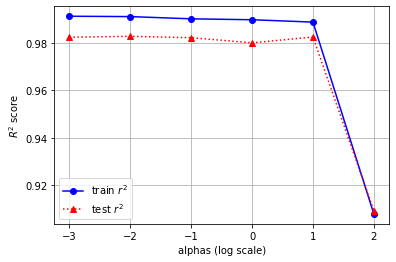

In [ ]:
visualize_r2_score('l1', X_tr, y_tr, X_te, y_te)

train scores : [0.9946716964073975, 0.9926658847510959, 0.9906588529802888, 0.9898642966685524, 0.9891003605036942, 0.9847161412052865]
test scores : [0.8805517581588203, 0.9675695452678644, 0.9829891528180518, 0.9805647119266162, 0.9749015716532, 0.9620345864309697]


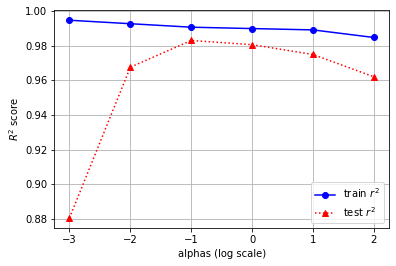

In [ ]:
visualize_r2_score('l2', X_tr, y_tr, X_te, y_te)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.363e+04, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.377e+04, tolerance: 5.183e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

train scores : [0.9911600197718459, 0.9903065264301221, 0.9896515210383674, 0.9883866962961532, 0.9807297352710089, 0.8298002302295657]
test scores : [0.9828728562837419, 0.9826006657730557, 0.9792857127589776, 0.9719870935292817, 0.9615684464630995, 0.8421891080992795]


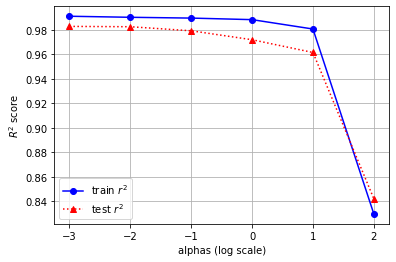

In [ ]:
visualize_r2_score('elastic', X_tr, y_tr, X_te, y_te)